# Merge datasets to produce final h5py

In [1]:
# Script to join RData with CSV
import pandas as pd
import numpy as np
import os
import sys

# Read in the RData file
rdata = pd.read_csv("RaCA-dataset-with-locations.csv")

## Collect fields of interest from rdata

In [2]:
rdata_fields = ['rcapid','rcasiteid','sample_id'] + [f'{x}' for x in range(365,2501)]
rdata['rcasiteid'] = rdata['rcapid'].str[:-1] # Remove the last character from the rcapid column to get the rcasiteid
rdata = rdata[rdata_fields] # Filter the rdata dataframe to only include the fields we want

# 'lat','long','region','landuse','group'
print(len(rdata))


121397


The RaCA database outputs many duplicate rows. We remove these, keeping the first.

In [3]:
rdata.drop_duplicates(inplace=True)

In [4]:
print(len(rdata))

115130


## Open XLSX file from RaCA admins and extract relevant data

In [5]:
# Read the data from the sheet named "RaCA_xy" in the Excel file
racaloc = pd.read_excel("RaCA_data_summary_download.xlsx", sheet_name="RaCA_xy", header=0)

racaloc = racaloc.rename(columns={'RaCA_site': 'rcasiteid'})
racaloc = racaloc.rename(columns={'Lat': 'lat'})
racaloc = racaloc.rename(columns={'Lon': 'long'})
racaloc = racaloc.rename(columns={'Region': 'region'})
racaloc = racaloc.rename(columns={'Landuse': 'landuse'})
racaloc = racaloc.rename(columns={'Group': 'group'})

racaloc.drop_duplicates(inplace=True)

Does ``racaloc`` contain unique ``rcasiteid`` values?

In [6]:
duplicates_racaloc = racaloc[racaloc.duplicated(subset='rcasiteid', keep=False)]
duplicate_counts_racaloc = duplicates_racaloc['rcasiteid'].value_counts()

print("Duplicate rcasiteid values in racaloc:")
print(duplicates_racaloc['rcasiteid'].unique())
print("Number of duplicates for each rcasiteid in racaloc:")
print(duplicate_counts_racaloc)

Duplicate rcasiteid values in racaloc:
['C0508R03']
Number of duplicates for each rcasiteid in racaloc:
rcasiteid
C0508R03    2
Name: count, dtype: int64


No. Check the duplicate:

In [7]:
duplicates_racaloc = racaloc[racaloc.duplicated(subset='rcasiteid', keep=False)]
print(duplicates_racaloc)


     rcasiteid        lat       long  region landuse  group
1515  C0508R03  41.168304 -98.831970       5       R      8
1516  C0508R03  41.168306 -98.831972       5       R      8


It's okay to remove the duplicate from ``racaloc`` by taking the first value.

In [8]:
# Assuming your dataframe is named 'df'
racaloc.drop_duplicates(inplace=True, subset=['rcasiteid'], keep='first')

Now get SOC data:

In [9]:
racasoc = pd.read_excel("RaCA_data_summary_download.xlsx", sheet_name="RaCA_samples_wmodelBD", header=0)
racasoc_fields = ['rcasiteid','sample.id','adod','c_tot_ncs','caco3']

racasoc = racasoc[racasoc['pedon_no'] == 1]
racasoc = racasoc[racasoc_fields]

racasoc = racasoc.rename(columns={'sample.id': 'sample_id'})

In [10]:
print(len(racasoc))

31347


In [11]:
# Assuming your dataframe is named 'df'
racaloc.drop_duplicates(inplace=True)
print(len(racasoc))

31347


In [12]:
duplicates_racasoc = racasoc[racasoc.duplicated(subset='sample_id', keep=False)]
duplicate_counts_racasoc = duplicates_racasoc['sample_id'].value_counts()

print("Duplicate sample_id values in racasoc:")
print(duplicates_racasoc['sample_id'].unique().astype(int))
print("Number of duplicates for each sample_id in racasoc:")
print(duplicate_counts_racasoc)

Duplicate sample_id values in racasoc:
[                   1                   72                  117
                 1918                 2529                 4052
                 5167                 5168                 6150
                13543                13902                14772
                18658                19333                19424
                19875                20893                21114
                21542                26153                26798
                26992                27002                27761
                30093                30327                31998
                32550                32572                32853
                33035 -9223372036854775808                43745
                43747                44175                54027
                57185                60479                61847
                75611                94653                95591
                96291                96469                96566
 

/tmp/ipykernel_3466101/2650515802.py:5: RuntimeWarning: invalid value encountered in cast
  print(duplicates_racasoc['sample_id'].unique().astype(int))


In [13]:
duplicates_racasoc = racasoc[racasoc.duplicated(subset='sample_id', keep=False)]
print(duplicates_racasoc)


       rcasiteid  sample_id      adod  c_tot_ncs      caco3
889     C0101F01        1.0  1.122646  48.094150        NaN
890     C0101F01        1.0  1.115296  50.142574        NaN
964     C0101W06       72.0  1.088957  30.258842  30.627863
965     C0101W06       72.0  1.087984  28.499728  25.770186
1011    C0101W08      117.0  1.110671  43.963696        NaN
...          ...        ...       ...        ...        ...
144248  F1504F06   120966.0  1.002366   0.952248        NaN
144418  F1507R03   123682.0  1.009164   2.573367        NaN
144419  F1507R03   123682.0  1.005626   1.377707        NaN
144963  F1809F94   142973.0  1.025607   4.049098   0.382128
144964  F1809F94   142973.0  1.023010   3.105858   0.276200

[232 rows x 5 columns]


We choose to discard these 232 entries entirely, as there is no documentation to explain their duplication.

In [14]:
print(len(racasoc))
racasoc.drop_duplicates(inplace=True, keep=False)
print(len(racasoc))
racasoc.drop_duplicates(inplace=True, subset=['sample_id'], keep=False)
print(len(racasoc))

31347
31345
31116


## Merge locations with rdata

In [15]:
# Join location data into spectral data
joined = pd.merge(rdata, racaloc, on='rcasiteid', how='left', validate='m:1')

In [16]:
# Join soil data into spectral data
joined = pd.merge(joined, racasoc, on='sample_id', how='inner', validate='1:1')

In [17]:
len(joined)

24300

## Cut out hydration outliers

Some of the samples have very high water content:

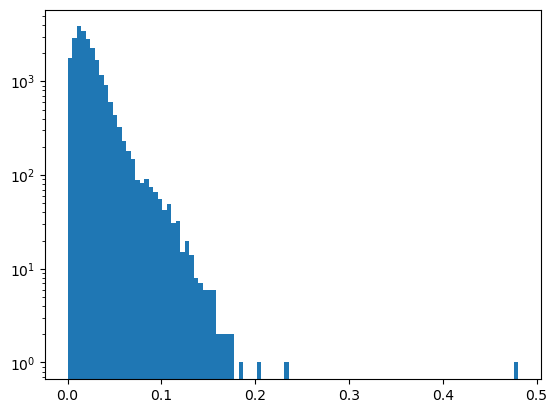

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

plt.hist([1-1/x for x in joined['adod']], bins=100)
plt.yscale('log')
plt.show()


Let's remove the single outlier at 48% moisture content.

In [19]:
index_to_drop = joined[joined['adod'].apply(lambda x: 1 - 1/x > 0.4)].index[0]
joined.drop(index_to_drop, inplace=True)

## Generate SOC data

Follow the procedure in the RaCA guidelines to handle caco3 values below 0.

In [20]:
print(((joined['c_tot_ncs'] >= 0).astype(int)).sum())
print(((joined['c_tot_ncs'] < 0).astype(int)).sum())


23590
0


In [21]:
joined = joined.dropna(subset=['c_tot_ncs'])
print(len(joined))

23590


In [22]:
print(((joined['caco3'] >= 0).astype(int)).sum())
print(((joined['caco3'] < 0).astype(int)).sum())

joined['caco3'] = joined['caco3'].fillna(0)
joined.loc[joined['caco3'] < 0, 'caco3'] = 0


13752
487


In [23]:
print(((joined['caco3'] >= 0).astype(int)).sum())
print(((joined['caco3'] < 0).astype(int)).sum())

23590
0


Now compute SOC:

In [24]:
joined['soc'] = joined['c_tot_ncs'] - 0.12*joined['caco3']

Let us check how frequently SOC is negative in abundance. Is it consistent with our assumed error of 0.41%?

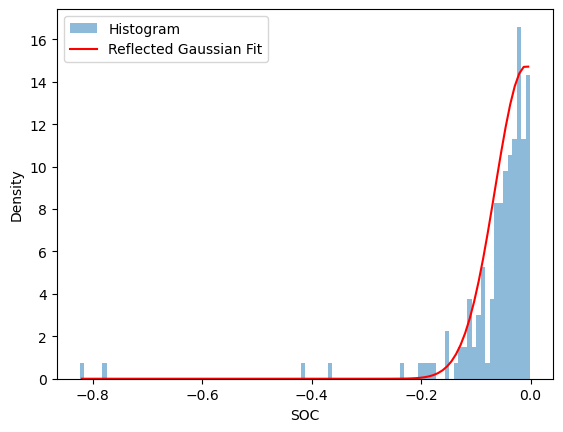

[-8.16789414e-03  5.67551424e-02  1.47441252e+01]


In [68]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the reflected Gaussian function
def reflected_gaussian(x, mu, sigma, amplitude):
    return amplitude * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Filter the data for negative SOC values
negative_soc = joined[(joined['soc'] < 0)]['soc']

# Generate the histogram
plt.hist(negative_soc, bins=100, density=True, alpha=0.5, label='Histogram')

# Get the histogram data
hist, bins = np.histogram(negative_soc, bins=100, density=True)

# Get the bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Fit the reflected Gaussian distribution
params, _ = curve_fit(reflected_gaussian, -bin_centers, hist)

# Generate the fitted curve
x = np.linspace(min(-bin_centers), max(-bin_centers), 100)
y = reflected_gaussian(-x, *params)

# Plot the fitted curve
plt.plot(-x, y, 'r-', label='Reflected Gaussian Fit')

# Set the plot labels and legend
plt.xlabel('SOC')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()
print(params)


It seems to be appropriate if we assume the negative values are all a proxy for the zero-SOC samples. Given this, set all negative-SOC samples to 0.

In [71]:
joined.loc[joined['soc'] < 0, 'soc'] = 0.

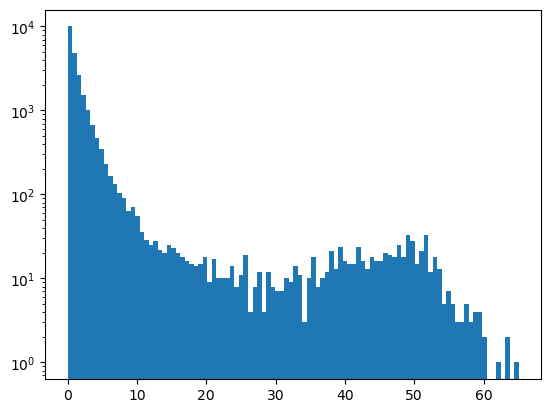

In [72]:
plt.hist(joined['soc'], bins=100);
plt.yscale('log')
plt.show()

In [184]:
print(((joined['soc'] < 0).astype(int)).sum())

161


In [186]:
joined[joined['soc'] < 0] = 0
print(((joined['soc'] < 0).astype(int)).sum())
print(((joined['soc'] >= 0).astype(int)).sum())

0
23590


Normalize percentages:

In [100]:
joined['soc'] = joined['soc'] / 100
joined['c_tot_ncs'] = joined['c_tot_ncs'] / 100
joined['caco3'] = joined['c_tot_ncs'] / 100

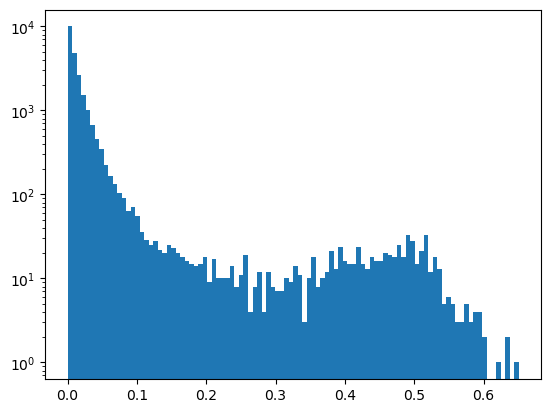

In [102]:
plt.hist(joined['soc'], bins=100);
plt.yscale('log')

## Postprocess spectra to remove dead pixels

Where are the dead pixels?

759


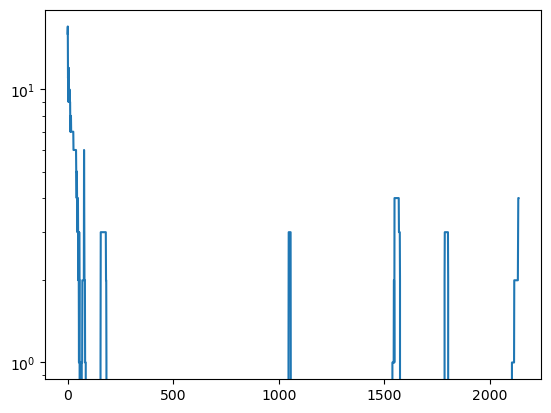

In [77]:
wavelengths = [x for x in range(365, 2501)]
wavelen_txt = [str(x) for x in wavelengths]

hist = plt.plot((joined[wavelen_txt] < 0).astype(int).sum(axis=0).to_numpy())
plt.yscale('log')
print(np.sum((joined[wavelen_txt] < 0).astype(int).to_numpy()))

What is the number of spectra that have dead pixels?

In [91]:
len(joined[(((joined[wavelen_txt] < 0).astype(int) + (joined[wavelen_txt] > 1).astype(int) + (np.isnan(joined[wavelen_txt])).astype(int)).max(axis=1) > 0)])

40

This is a small number, so delete these 40 spectra and check that this worked.

In [92]:
joined = joined.drop(joined[(((joined[wavelen_txt] < 0).astype(int) + (joined[wavelen_txt] > 1).astype(int) + (np.isnan(joined[wavelen_txt])).astype(int)).max(axis=1) > 0)].index)


In [99]:
print("Number of scans with dead pixels:",len(joined[(((joined[wavelen_txt] < 0).astype(int) + (joined[wavelen_txt] > 1).astype(int) + (np.isnan(joined[wavelen_txt])).astype(int)).max(axis=1) > 0)]))
print("Number of scans without dead pixels:",len(joined[(((joined[wavelen_txt] < 0).astype(int) + (joined[wavelen_txt] > 1).astype(int) + (np.isnan(joined[wavelen_txt])).astype(int)).max(axis=1) == 0)]))

Number of scans with dead pixels: 0
Number of scans without dead pixels: 23550


## Save to file

In [106]:
[x for x in joined.columns if x not in wavelen_txt]

['rcapid',
 'rcasiteid_x',
 'sample_id',
 'lat',
 'long',
 'region',
 'landuse',
 'group',
 'rcasiteid_y',
 'adod',
 'c_tot_ncs',
 'caco3',
 'soc']

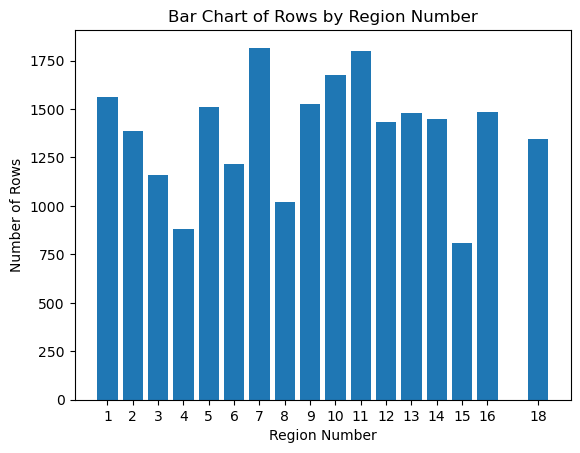

In [117]:
import pandas as pd
import matplotlib.pyplot as plt

# Access the 'region' column in the 'joined' dataframe
region_counts = joined['region'].value_counts()

# Create a bar chart
plt.bar(region_counts.index, region_counts.values)

# Add labels and title
plt.xlabel('Region Number')
plt.ylabel('Number of Rows')
plt.title('Bar Chart of Rows by Region Number')

# Set x ticks as integers
plt.xticks(region_counts.index)

# Display the bar chart
plt.show()


In [133]:
import torch
import numpy as np

with h5py.File("ICLRDataset_RaCASpectraAndSOC.h5", 'w') as hRaCA :
    with h5py.File("ICLRDataset_SplitIndices.h5","w") as hInds :

        for region in joined['region'].unique():
            region_rows = joined[joined['region'] == region]
            indices = torch.tensor(region_rows.index)
            dsetInds = hInds.create_dataset(f'{region}_indices', data=indices) 

            print(f'{region}: {len(region_rows)} rows with min index {region_rows.index.min()} and max index {region_rows.index.max()}')

            # select 10 random pedons from the region
            # using rcapid as the unique id associated to each pedon
            # where each pedon can have multiple rows in the region
            # and each row has a unique index
            pedon_ids = region_rows['rcapid'].unique()

            for bootstrap_index in range(10) :

                # select 10 unique random pedons from the region
                bootstrap_pedons = np.random.choice(pedon_ids, 10, replace=False)

                # select all rows from the region that are in the 10 random pedons
                bootstrap_rows = region_rows[region_rows['rcapid'].isin(bootstrap_pedons)]

                # save the bootstrap rows to the h5 file
                bootInds = hInds.create_dataset(f'{region}_bootstrap_{bootstrap_index}', data=torch.tensor(bootstrap_rows.index))

                print(f'{region} bootstrap {bootstrap_index}: {len(bootstrap_rows)} bootstrap rows with min index {bootstrap_rows.index.min()} and max index {bootstrap_rows.index.max()}')


        for index, row in joined.iterrows():
            dsetRaCA = hRaCA.create_dataset(f'{index}', data=torch.tensor(row[wavelen_txt + ['soc']]))
                

4: 880 rows with min index 1 and max index 19247
4 bootstrap 0: 44 bootstrap rows with min index 1568 and max index 10420
4 bootstrap 1: 47 bootstrap rows with min index 454 and max index 6663
4 bootstrap 2: 48 bootstrap rows with min index 421 and max index 7839
4 bootstrap 3: 44 bootstrap rows with min index 479 and max index 6494
4 bootstrap 4: 53 bootstrap rows with min index 1 and max index 7845
4 bootstrap 5: 40 bootstrap rows with min index 1 and max index 6463
4 bootstrap 6: 47 bootstrap rows with min index 2004 and max index 10381
4 bootstrap 7: 50 bootstrap rows with min index 421 and max index 6490
4 bootstrap 8: 50 bootstrap rows with min index 503 and max index 19247
4 bootstrap 9: 45 bootstrap rows with min index 1346 and max index 19247
1: 1561 rows with min index 6 and max index 13599
1 bootstrap 0: 52 bootstrap rows with min index 177 and max index 2345
1 bootstrap 1: 46 bootstrap rows with min index 36 and max index 2327
1 bootstrap 2: 42 bootstrap rows with min index